In [1]:
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn
import matplotlib.pyplot as pyplot
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import pandas
import numpy
import wandb
from wandb.keras import WandbCallback

wandb.login(key='ea1404a9d16ac9056181f111599286f24c65e0e9')
wandb.init(project='covid19', entity='ashuto7h')
config = wandb.config


2021-11-13 14:40:22.419857: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ashuto7h (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2021-11-13 14:40:31.309948: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
sdir = r'../input/large-covid19-ct-slice-dataset/curated_data/curated_data'
filepaths = []
labels = []
classlist = os.listdir(sdir)
for item in classlist:
    classpath = os.path.join(sdir, item)
    flist = os.listdir(classpath)
    for f in flist:
        fpath = os.path.join(classpath, f)
        filepaths.append(fpath)
        labels.append(item)

df = pandas.DataFrame()
df['filepath'] = filepaths
df['labels'] = labels
print(df['labels'].value_counts())
df = df.sample(frac=1).reset_index(drop=True)



CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



2COVID       7593
1NonCOVID    6893
3CAP         2618
Name: labels, dtype: int64


In [3]:
cw = compute_class_weight('balanced', classes=df.labels.unique(), y=df.labels)
print(cw, df.labels.unique())


[0.8271193  0.75086703 2.17774382] ['1NonCOVID' '2COVID' '3CAP']


In [4]:
class_weights = {2: 2.17774382, 0: 0.8271193, 1: 0.75086703}
class_map = {'2COVID': 1, '1NonCOVID': 0, '3CAP': 2}


In [5]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, shuffle=True, color_mode="rgb"):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.on_epoch_end()
        self.color_mode = color_mode
        self.augmentor = keras.preprocessing.image.ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            brightness_range=[0, 0.2])

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index *
                           self.batch_size:(index + 1) *
                           self.batch_size]
        batch = [self.indices[k] for k in index]

        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = numpy.arange(len(self.indices))
        if self.shuffle == True:
            numpy.random.shuffle(self.index)

    def __get_data(self, batch):
        X = []
        y = []
        for i, id in enumerate(batch):
            img = tf.keras.preprocessing.image.load_img(
                self.df.loc[id, 'filepath'],
                color_mode=self.color_mode,
                target_size=(256, 256),
                interpolation="nearest")
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            X.append(img_array/255)
            ylist = [0, 0, 0]
            ylist[class_map[self.df.loc[id, 'labels']]] = 1
            ylist = numpy.array(ylist)
            y.append(ylist)
        X = numpy.array(X)
#         X = self.augmentor.flow(X, batch_size=self.batch_size, shuffle=False).next()
        y = numpy.array(y)
        return X, y


In [6]:
train_data = DataGenerator(
    df[:13684].reset_index(drop=True), batch_size=32)  # 80%
valid_data = DataGenerator(df[13684:15394].reset_index(
    drop=True), batch_size=32)  # 80 - 90%
test_data = DataGenerator(df[15394:].reset_index(
    drop=True), shuffle=False, batch_size=32)  # 90 - 100%

# train_data = DataGenerator(df[:200].reset_index(drop=True))  # 80%
# valid_data = DataGenerator(df[200:300].reset_index(drop=True))  # 80 - 90%
# test_data = DataGenerator(df[300:400].reset_index(drop=True), shuffle=False)  # 90 - 100%


In [7]:
def conv_block(filters, inputs):
    # filters of size 3x3
    x = layers.SeparableConv2D(
        filters, 3,
        activation="relu",
        padding="same")(inputs)
    x = layers.SeparableConv2D(
        filters, 3,
        activation="relu",
        padding="same")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.MaxPool2D()(x)
    return outputs


def dense_block(units, dropout_rate, inputs):
    x = layers.Dense(units, activation="relu")(inputs)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.BatchNormalization()(x)
    return outputs


In [8]:
def build_model():
    inputs = keras.Input(shape=(256, 256, 3))
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPool2D()(x)
    x = conv_block(64, x)
    x = conv_block(128, x)
    x = conv_block(256, x)
    x = conv_block(512, x)
    x = layers.GlobalAvgPool2D()(x)
    x = dense_block(128, 0.3, x)
    x = dense_block(64, 0.3, x)
    outputs = layers.Dense(3, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [9]:
initial_learning_rate = 0.015
epochs = 100
model_name = "Custom_v26.h5"
patience = 10
decay_steps = 100000
decay_rate = 0.96
batch_size = 32
# easy sweep 10 | sweep = custom cnn 0.8125
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    model_name,
    save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=patience,
    restore_best_weights=True)


In [10]:
config.class_weights = class_weights
config.class_map = class_map
config.initial_learning_rate = initial_learning_rate
config.epochs = epochs
config.model_name = model_name
config.patience = patience
config.decay_steps = decay_steps
config.decay_rate = decay_rate
config.batch_size = batch_size


In [11]:
model = build_model()
wandb.log({'model_summary': model.summary()})
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=METRICS
)

history = model.fit(
    train_data,
    epochs=epochs,
    class_weight=class_weights,
    verbose=1,
    validation_data=valid_data,
    workers=2,
    callbacks=[checkpoint_cb, early_stopping_cb, WandbCallback()],
)


2021-11-13 14:40:46.314721: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-13 14:40:46.319398: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-13 14:40:46.366934: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 14:40:46.368130: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-11-13 14:40:46.368236: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-11-13 14:40:46.398853: I tensorflow/stream_executor/platform/def

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 128, 128, 64)      2400      
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 128, 128, 64)      4736      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0     

2021-11-13 14:40:49.731167: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-13 14:40:49.735467: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/100


2021-11-13 14:40:52.189945: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-11-13 14:40:53.349509: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-11-13 14:40:53.402085: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


427/427 [==============================] - 160s 351ms/step - loss: 0.9371 - accuracy: 0.5218 - precision: 0.5794 - recall: 0.4125 - val_loss: 1.6292 - val_accuracy: 0.3037 - val_precision: 0.2359 - val_recall: 0.1633
Epoch 2/100
427/427 [==============================] - 123s 286ms/step - loss: 0.6787 - accuracy: 0.7037 - precision: 0.7480 - recall: 0.6265 - val_loss: 8.6515 - val_accuracy: 0.2824 - val_precision: 0.2824 - val_recall: 0.2824
Epoch 3/100
427/427 [==============================] - 124s 288ms/step - loss: 0.6305 - accuracy: 0.7366 - precision: 0.7757 - recall: 0.6764 - val_loss: 1.8795 - val_accuracy: 0.5666 - val_precision: 0.5685 - val_recall: 0.5625
Epoch 4/100
427/427 [==============================] - 122s 285ms/step - loss: 0.5762 - accuracy: 0.7609 - precision: 0.7852 - recall: 0.7263 - val_loss: 1.3394 - val_accuracy: 0.5389 - val_precision: 0.5399 - val_recall: 0.5389
Epoch 5/100
427/427 [==============================] - 122s 285ms/step - loss: 0.5228 - accuracy

## Hyper parameter Tuning


In [12]:
# sweep_config = {
#   "name" : "custom_cnn sweep",
#   "method" : "random",
#   "parameters" : {
#     "epochs" : {
#       "min" : 25,
#       "max" : 100
#     },
#     "learning_rate" :{
#       "min": 0.00001,
#       "max": 0.1
#     },
#     "batch_size":{
#         "values":[2,4,8,16,32,64,128,256]
#     },
#     "decay_steps":{
#         "min":100,
#         "max":100000
#     },
#     "decay_rate":{
#         "min":0.7,
#         "max":0.96
#     },
#   },
#   "metric":{
#       "name":"valid_accuracy",
#       "goal":"maximize"
#   }
# }

# sweep_id = wandb.sweep(sweep_config)
# i = 0
# def train():
#     global i
#     i += 1
#     with wandb.init(project='covid19', entity='ashuto7h') as run:
#         config = run.config
#         train_data = DataGenerator(df[:9000].reset_index(drop=True),batch_size=config.batch_size)  # 80%
#         valid_data = DataGenerator(df[9000:11000].reset_index(drop=True),batch_size=config.batch_size)  # 80 - 90%
#         lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#             config.learning_rate,
#             decay_steps=config.decay_steps,
#             decay_rate=config.decay_rate,
#             staircase=True)
#         checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
#             f'custom_sweep_{i}',
#             save_best_only=True)
#         early_stopping_cb = tf.keras.callbacks.EarlyStopping(
#             patience=10,
#             restore_best_weights=True)
#         history = model.fit(
#             train_data,
#             epochs=config.epochs,
#             class_weight=class_weights,
#             verbose=0,
#             validation_data=valid_data,
#             workers=2,
#             callbacks=[checkpoint_cb, early_stopping_cb],
#         )
#         wandb.log({"loss": history.history['loss'][-1]})
#         wandb.log({"accuracy":history.history['accuracy'][-1]})
#         wandb.log({"valid_accuracy":history.history['val_accuracy'][-1]})
#         wandb.log({"precision":history.history['precision'][-1]})
#         wandb.log({"recall":history.history['recall'][-1]})
#         wandb.log({"val_loss":history.history['val_loss'][-1]})
#         wandb.log({"val_precision":history.history['val_precision'][-1]})
#         wandb.log({"val_recall":history.history['val_recall'][-1]})

# count = 10
# wandb.agent(sweep_id, function=train, count=count)


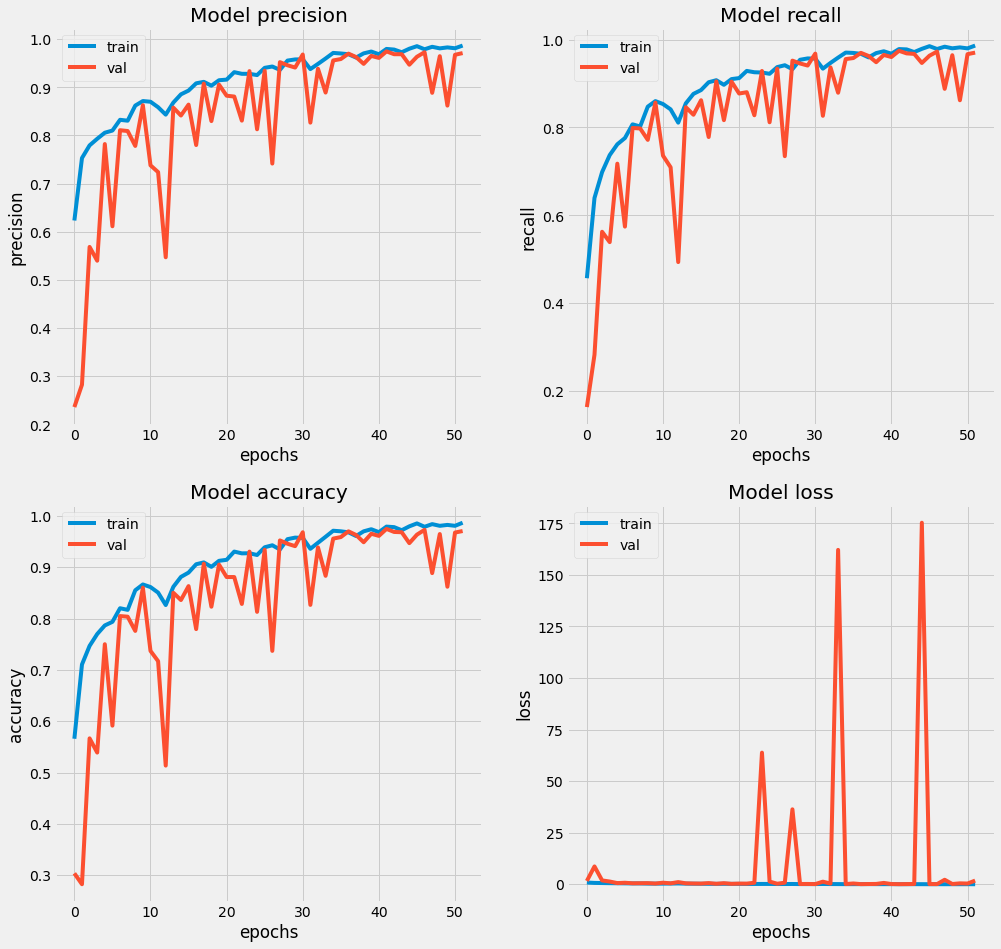

In [13]:
pyplot.style.use('fivethirtyeight')
fig, ax = pyplot.subplots(2, 2, figsize=(15, 15))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])
try:
    wandb.log({'training log img': wandb.Image(fig)})
except:
    pass


In [14]:
train_eval = model.evaluate(train_data, return_dict=True)
wandb.log({'train evaluation': train_eval})
display('train evaluation\n', train_eval)

valid_eval = model.evaluate(valid_data, return_dict=True)
wandb.log({'valid evaluation': valid_eval})
display('valid evaluation\n', valid_eval)

test_eval = model.evaluate(test_data, return_dict=True)
wandb.log({'test evaluation': test_eval})
display('test evaluation\n', test_eval)


427/427 [==============================] - 99s 232ms/step - loss: 0.0438 - accuracy: 0.9908 - precision: 0.9909 - recall: 0.9907


'train evaluation\n'

{'loss': 0.04380442947149277,
 'accuracy': 0.9907786846160889,
 'precision': 0.9908505082130432,
 'recall': 0.9907054901123047}

53/53 [==============================] - 13s 239ms/step - loss: 0.0688 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746


'valid evaluation\n'

{'loss': 0.06876692920923233,
 'accuracy': 0.9746462106704712,
 'precision': 0.9746462106704712,
 'recall': 0.9746462106704712}

53/53 [==============================] - 27s 518ms/step - loss: 5.4632 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764


'test evaluation\n'

{'loss': 5.463168144226074,
 'accuracy': 0.9764150977134705,
 'precision': 0.9764150977134705,
 'recall': 0.9764150977134705}

In [15]:


def get_class(value):
    for key in class_map.keys():
        if class_map[key] == value:
            return key


get_class(2)


'3CAP'

### Confusion matrix - validation


53/53 [==============================] - 13s 236ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       666
           1       0.97      0.98      0.97       743
           2       1.00      1.00      1.00       287

    accuracy                           0.97      1696
   macro avg       0.98      0.98      0.98      1696
weighted avg       0.97      0.97      0.97      1696



<AxesSubplot:>

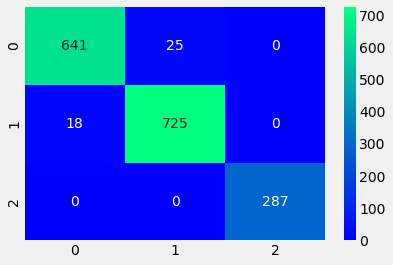

In [16]:

labels = []
for image, label in valid_data:
    labels.append(label)

labels = numpy.array(labels).reshape(-1, 3)
predictions = model.predict(valid_data, verbose=1)
labels = numpy.argmax(labels, axis=-1)
y_pred = numpy.argmax(predictions, axis=-1)

# get the classification report
cr = classification_report(labels, y_pred)
print(cr)
cm = confusion_matrix(labels, y_pred)
x = seaborn.heatmap(cm, cmap='winter', annot=True, fmt='d')
try:
    wandb.log({'confusion matrix valid img': wandb.Image(x)})
except:
    pass
display(x)


53/53 [==============================] - 13s 242ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       707
           1       0.97      0.98      0.97       735
           2       1.00      0.99      1.00       254

    accuracy                           0.98      1696
   macro avg       0.98      0.98      0.98      1696
weighted avg       0.98      0.98      0.98      1696



<AxesSubplot:>

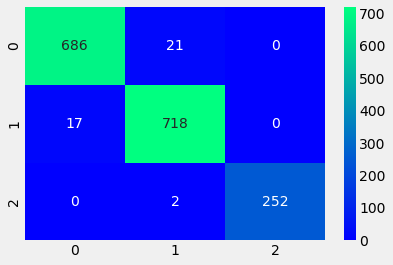

In [17]:
labels = []
for image, label in test_data:
    labels.append(label)

labels = numpy.array(labels).reshape(-1, 3)
predictions = model.predict(test_data, verbose=1)
labels = numpy.argmax(labels, axis=-1)
y_pred = numpy.argmax(predictions, axis=-1)

# get the classification report
cr = classification_report(labels, y_pred)
print(cr)
cm = confusion_matrix(labels, y_pred)
x = seaborn.heatmap(cm, cmap='winter', annot=True, fmt='d')
try:
    wandb.log({'confusion matrix test img': wandb.Image(x)})
except:
    pass
display(x)
